In [1]:
import torch
import numpy as np
import torch.nn as nn
from models import sam_model_registry, SamPredictor

# Load model
sam_checkpoint = "./src/sam_pretrained/sam_vit_l_0b3195.pth"
model_type = "vit_l"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam = torch.nn.DataParallel(sam).cuda()
sam = sam.module

predictor = SamPredictor(sam)

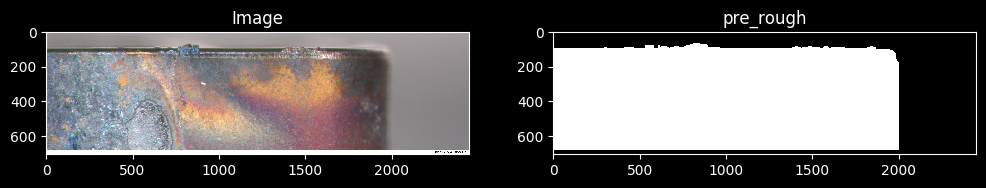

In [2]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
# Load image
# display a specific image
random_image_path = "./src/Tool_Detection/3_PDImpression/PPP538_U10081_DP1/Flank/PPP538 14,2 30 snitt_ID161010602.jpg"
random_gt_path = random_image_path.rsplit(".", 1)[0] + "_bitmap.jpg"
image = np.array(Image.open(random_image_path).convert('RGB'))
gt = np.array(Image.open(random_gt_path).convert('L'))

# Display images using matplotlib
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Image")
plt.subplot(1, 2, 2)
plt.imshow(gt, cmap='gray')
plt.title("pre_rough")
plt.show()

In [3]:
image_resized = cv2.resize(image, (1024,1024), interpolation=cv2.INTER_NEAREST)
gt_resized = cv2.resize(gt, (1024,1024), interpolation=cv2.INTER_NEAREST)
outputs_lowres = nn.MaxPool2d(4)(torch.tensor(gt_resized).unsqueeze(0).float())
# predict with sam
predictor.set_image(image_resized)
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    mask_input=outputs_lowres,
    multimask_output=True,
)
predictor.reset_image()
    
pre_bitmap = cv2.resize(masks[0].astype(np.uint8), (gt.shape[1],gt.shape[0]), interpolation=cv2.INTER_NEAREST)
# Display images using matplotlib
# Overlay mask on image, using RED channel for mask
if len(pre_bitmap.shape) == 2:  # Check if pre_mask is a single channel image
    pre_bitmap_3c = cv2.cvtColor(pre_bitmap*255, cv2.COLOR_GRAY2BGR)  # Convert to 3 channel image
image_with_mask = cv2.addWeighted(image, 0.7, pre_bitmap_3c, 0.3, 0)

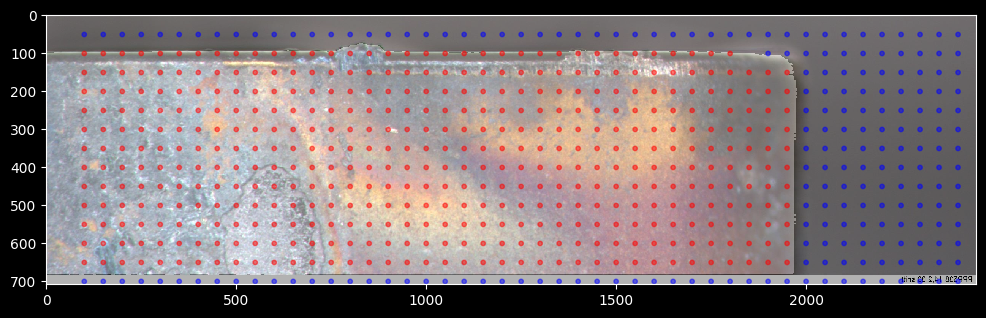

In [4]:
# Find all the array points inside the mask
contours, _ = cv2.findContours(pre_bitmap, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
max_contour = max(contours, key=cv2.contourArea)
mask = np.zeros_like(pre_bitmap)
cv2.drawContours(mask, [max_contour], -1, (255), thickness=cv2.FILLED)

grid_spacing = 50
height, width = mask.shape
points_inside_contour = []
points_outside_contour = []
for y in range(50, height, grid_spacing):
    for x in range(100, width, grid_spacing):
        if cv2.pointPolygonTest(max_contour, (x, y), False) > 0:
            points_inside_contour.append([x, y])

for y in range(50, height, grid_spacing):
    for x in range(100, width, grid_spacing):
        if cv2.pointPolygonTest(max_contour, (x, y), False) < 0:
            points_outside_contour.append([x, y])

input_point = np.array(points_inside_contour + points_outside_contour)
input_label = [1]*len(points_inside_contour) + [0]*len(points_outside_contour)

if len(pre_bitmap.shape) == 2:  # Check if pre_mask is a single channel image
    pre_bitmap_3c = cv2.cvtColor(pre_bitmap*255, cv2.COLOR_GRAY2BGR)  # Convert to 3 channel image
image_with_mask = cv2.addWeighted(image, 0.7, pre_bitmap_3c, 0.3, 0)
plt.figure(figsize=(12, 6))
plt.imshow(image_with_mask)
plt.scatter(input_point[:, 0], input_point[:, 1], c=input_label, cmap='bwr', s=10, alpha=0.5)

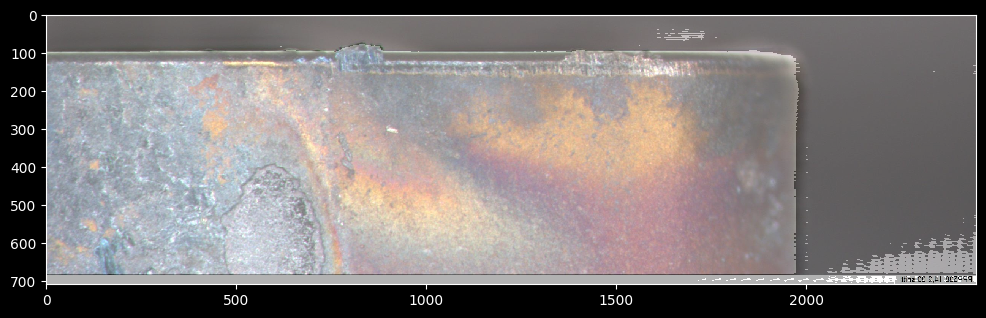

In [5]:
pre_bitmap_resized = cv2.resize(gt, (1024,1024), interpolation=cv2.INTER_NEAREST)
outputs_lowres = nn.MaxPool2d(4)(torch.tensor(pre_bitmap_resized).unsqueeze(0).float())
# predict with sam
predictor.set_image(image_resized)
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=outputs_lowres,
    multimask_output=True,
)
predictor.reset_image()
    
pre_bitmap = cv2.resize(masks[0].astype(np.uint8), (gt.shape[1],gt.shape[0]), interpolation=cv2.INTER_NEAREST)

# Display images using matplotlib
# Overlay mask on image, using RED channel for mask
if len(pre_bitmap.shape) == 2:  # Check if pre_mask is a single channel image
    pre_bitmap_3c = cv2.cvtColor(pre_bitmap*255, cv2.COLOR_GRAY2BGR)  # Convert to 3 channel image
image_with_mask = cv2.addWeighted(image, 0.7, pre_bitmap_3c, 0.3, 0)
plt.figure(figsize=(12, 6))
plt.imshow(image_with_mask)

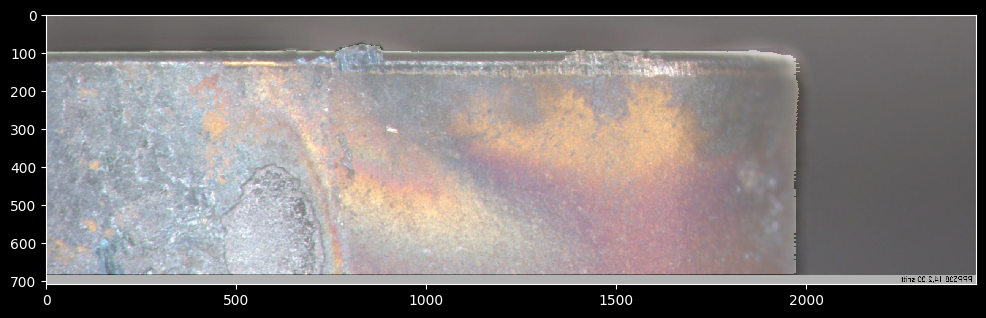

: 

In [7]:

def mask_filter(pre_bitmap):
    area_threshold = 10
    contours, _ = cv2.findContours(pre_bitmap, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_contour = max(contours, key=cv2.contourArea)

    mask = np.zeros_like(pre_bitmap)
    cv2.drawContours(mask, [max_contour], -1, (1), thickness=cv2.FILLED)
    
    return mask

pre_bitmap = mask_filter(pre_bitmap)
# Display images using matplotlib
# Overlay mask on image, using RED channel for mask
if len(pre_bitmap.shape) == 2:  # Check if pre_mask is a single channel image
    pre_bitmap_3c = cv2.cvtColor(pre_bitmap*255, cv2.COLOR_GRAY2BGR)  # Convert to 3 channel image
image_with_mask = cv2.addWeighted(image, 0.7, pre_bitmap_3c, 0.3, 0)
plt.figure(figsize=(12, 6))
plt.imshow(image_with_mask)